In [23]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load data
data = pd.read_csv("LSTM_comparison.csv")

# Inspect
print(data.head())

   Actual  Predicted
0  1826.6  1807.2191
1  1835.2  1798.7146
2  1836.2  1812.6833
3  1840.8  1801.9944
4  1868.0  1822.8729


In [24]:
# Ensure data structure is correct
data['Predicted_Change'] = data['Predicted'].pct_change()
data['Actual_Change'] = data['Actual'].pct_change()

# Calculate Rolling Volatility (20-day standard deviation)
data['Volatility'] = data['Actual'].pct_change().rolling(window=20).std()

# Define Dynamic Signal Threshold
data['Threshold'] = 0.5 * data['Volatility']  # Adjust the multiplier (0.5) as needed

# Define prediction confidence based on the magnitude of Predicted_Change
data['Confidence'] = data['Predicted_Change'].abs()

# Generate Initial Buy/Sell/Hold Signals
data['Signal'] = data.apply(
    lambda row: 1 if row['Predicted_Change'] > row['Threshold'] else 
                (-1 if row['Predicted_Change'] < -row['Threshold'] else 0),
    axis=1
)

# Add Momentum Confirmation (20-day SMA)
data['SMA'] = data['Actual'].rolling(window=20).mean()
data['Confirmed_Signal'] = data.apply(
    lambda row: row['Signal'] if 
                (row['Signal'] == 1 and row['Actual'] > row['SMA']) or
                (row['Signal'] == -1 and row['Actual'] < row['SMA'])
                else 0,
    axis=1
)

# Stop-Loss and Take-Profit Rules
data['Stop_Loss'] = -2 * data['Volatility']  # Stop-loss at -2x volatility
data['Take_Profit'] = 2 * data['Volatility']  # Take-profit at 2x volatility


In [25]:
# Initialize Variables for Trading Simulation
data['Position'] = 0
data['PnL'] = 0
position_open = False

# Trading Simulation
for i in range(1, len(data)):
    if not position_open:
        # Open position if a confirmed signal exists
        if data.loc[i, 'Confirmed_Signal'] != 0:
            data.loc[i, 'Position'] = data.loc[i, 'Confirmed_Signal']
            entry_price = data.loc[i, 'Actual']
            position_open = True
    else:
        # Calculate return since entry
        current_price = data.loc[i, 'Actual']
        return_since_entry = (current_price - entry_price) / entry_price

        # Check Stop-Loss or Take-Profit
        if return_since_entry <= data.loc[i, 'Stop_Loss'] or return_since_entry >= data.loc[i, 'Take_Profit']:
            # Close position
            data.loc[i, 'Position'] = 0
            data.loc[i, 'PnL'] = return_since_entry
            position_open = False
        else:
            # Maintain position
            data.loc[i, 'Position'] = data.loc[i - 1, 'Position']

In [26]:
# Strategy Returns
data['Strategy_Return'] = data['PnL'].fillna(0)
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
data['Cumulative_Benchmark_Return'] = (1 + data['Actual_Change']).cumprod()

In [27]:
import numpy as np

# Performance Metrics
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std()
downside_returns = data['Strategy_Return'][data['Strategy_Return'] < 0]
sortino_ratio = data['Strategy_Return'].mean() / downside_returns.std()
mdd = (data['Cumulative_Strategy_Return'].cummax() - data['Cumulative_Strategy_Return']).max()
calmar_ratio = data['Cumulative_Strategy_Return'].iloc[-1] / abs(mdd) if mdd != 0 else np.nan
win_rate = len(data[data['Strategy_Return'] > 0]) / len(data[data['Strategy_Return'] != 0])

# Print Metrics
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Sortino Ratio: {sortino_ratio:.4f}")
print(f"Max Drawdown (MDD): {mdd:.4%}")
print(f"Calmar Ratio: {calmar_ratio:.4f}")
print(f"Win Rate: {win_rate:.4%}")

Sharpe Ratio: 0.0307
Sortino Ratio: 0.0399
Max Drawdown (MDD): 16.5856%
Calmar Ratio: 7.0161
Win Rate: 54.5455%


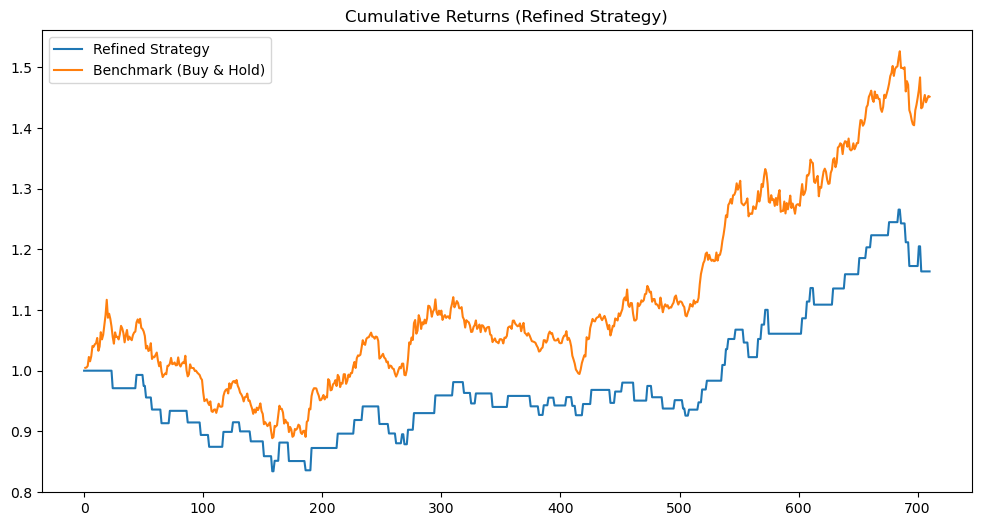

In [28]:
import matplotlib.pyplot as plt

# Plot Performance
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Return'], label="Refined Strategy")
plt.plot(data['Cumulative_Benchmark_Return'], label="Benchmark (Buy & Hold)")
plt.title("Cumulative Returns (Refined Strategy)")
plt.legend()
plt.show()